<a href="https://colab.research.google.com/github/Najam-ul-islam/00_text-analysis-pipeline/blob/main/00_text_analysis_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Analysis Pipeline
In this project, we need to perform the multi-step text analysis pipeline.Our use case will focus on processing a given text through three key stages:

1. Text Classification: We'll categorize the input text into predefined categories (e.g., News, Blog, Research, or Other).
2. Entity Extraction: We'll identify and extract key entities such as persons, organizations, and locations from the text.
3. Text Summarization: Finally, we'll generate a concise summary of the input text.

In [1]:
%%capture --no-stderr
%pip install -U langchain_google_genai langchain langchain_core langgraph, python-dotenv

In [2]:
!pip install Ipython

In [6]:
import os, getpass

def _set_env(var:str):
  if not os.environ.get(var):
    os.environ[var] = getpass.getpass(f"{var}")
_set_env("GOOGLE_API_KEY")

GOOGLE_API_KEY··········


In [18]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, List
from langchain.prompts import PromptTemplate
from IPython.display import display, Image
from langchain.schema import HumanMessage, AIMessage

### Setup LLM

In [19]:
os.environ["GOOGLE_API_KEY"] = os.getenv('GOOGLE_API_KEY')
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

In [20]:
# llm.invoke("who are you?")

### Define State Schema

In [21]:
class State(TypedDict):
  text:str
  classification:str
  entities:List[str]
  summary:str


### Create Nodes

In [30]:
# classification_node
def classify_text(state: State):
  ''' Classify the text into one of the categories: News, Blog, Research, or Other '''
  prompt = PromptTemplate(
      input_variable = ["text"],
      template = """
      Classify the following text into one of the categories: News, Blog, Research, or Other.\n\n
      Text:{text}\n\nCategory:
      """)
  message = HumanMessage(content=prompt.format(text=state["text"]))
  classified_text = llm.invoke([message]).content.strip()
  return {"classification": classified_text}

# Extract_entities_node
def extract_entities(state: State):
  ''' Extract entities from the text '''
  prompt = PromptTemplate(
      input_variable = ["text"],
      template = """Extract all the entities (Person, Organization, Location) from the following text.
      Provide the result as a comma-separated list.\n\nText:{text}\n\nEntities:"""
  )
  message = HumanMessage(content=prompt.format(text=state["text"]))
  entities = llm.invoke([message]).content.strip()
  return {"entities": entities.split(",")}

# Summarize_node
def summarize_text(state: State):
  ''' Summarize the text '''
  prompt = PromptTemplate(
      input_variable = ["text"],
      template = """Summarize the following text in 100 words or less.\n\nText:{text}\n\nSummary:"""
  )
  message = HumanMessage(content=prompt.format(text=state["text"]))
  summary = llm.invoke([message]).content.strip()
  return {"summary": summary}

### Create StateGraph workflow

In [31]:
graph_builder = StateGraph(State)

# Add nodes to the graph
graph_builder.add_node("classification_node",classify_text)
graph_builder.add_node("entitie_extraction_node", extract_entities)
graph_builder.add_node("summarize_node", summarize_text)

# create Edges between Nodes
graph_builder.add_edge(START, "classification_node")
graph_builder.add_edge("classification_node", "entitie_extraction_node")
graph_builder.add_edge("entitie_extraction_node", "summarize_node")
graph_builder.add_edge("summarize_node", END)

# compile the graph
graph = graph_builder.compile()


### Visualize the Graph

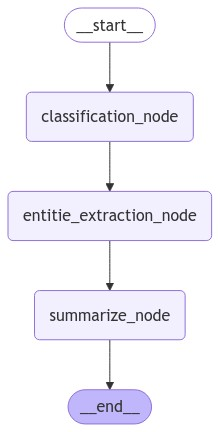

In [32]:
display(
    Image(graph.get_graph().draw_mermaid_png())
)

### Testing the Pipeline

In [33]:
text = """
In Chains, a sequence of actions is hardcoded. In Agents, a language model is used as a reasoning engine to determine which actions to take and in which order
"""

# input the text in dictionary(key:value) form
text_input = {"text": text}

# invoke the graph with the input text
result = graph.invoke(text_input)

# print the results

print(f"Classification: {result['classification']}")
print(f"Entities: {result['entities']}")
print(f"Summary: {result['summary']}")

Classification: The category is **Other**. 

Here's why:

* **News:** This text doesn't report on current events.
* **Blog:**  While it could be part of a blog post, it's too technical and lacks the typical blog elements like personal opinions or anecdotes.
* **Research:** This text is more of a conceptual comparison than a research finding. It doesn't present data or analysis.

**The text appears to be a technical explanation or comparison of two concepts (Chains and Agents) within a specific field, likely related to artificial intelligence or programming.**
Entities: ['Chains', ' Agents']
Summary: "Chains" are rigid, pre-programmed sequences of actions, while "Agents" employ language models to dynamically decide actions and their order.  This means agents are more flexible and adaptable, while chains are predictable and less complex.
